# Parameter Estimation for Ion Exchange

This demonstration will present the steps for setting up and conducting a parameter estimation for the WaterTAP ion exchange (IX) model. This tutorial will go through the steps to fit the IX model to breakthrough data for PFAS species. 

## Model Equations

The [WaterTAP IX model](https://watertap.readthedocs.io/en/stable/technical_reference/unit_models/ion_exchange_0D.html) we will be using is an implementation of the Clark model. This model includes three parameters related to the bed capacity, equilibrium, and mass transfer of the solute of interest on to the media. The governing equation is shown below.

$$
\frac{\textcolor{red}{C_b}}{\textcolor{red}{C_0}} =
\frac{1}{\left( 1 +
\left(2^{\textcolor{RoyalBlue}{n} - 1} - 1\right)
\exp\left[
\frac{\textcolor{RoyalBlue}{k_T} Z (\textcolor{RoyalBlue}{n} - 1)}
{\textcolor{RoyalBlue}{BV_{50}} \, u_{bed}}
\left(\textcolor{RoyalBlue}{BV_{50}} - \textcolor{green}{BV}\right)
\right]
\right)^{\tfrac{1}{\textcolor{RoyalBlue}{n} - 1}}}
$$

<!-- **Color Legend:**   -->
- $u_{bed}$ = bed loading rate, adopted from pilot experiments
- $Z$ = bed depth, adopted from pilot experiments
- $\textcolor{red}{C_b/C_0}$ = Effluent concentration ratio, determined from pilot experiments
- $\textcolor{green}{BV}$ = Bed volumes treated, determined from pilot experiments
- $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ = Clark model parameters to be fit with parameter estimation

In essence, we want to estimate the values for $\textcolor{RoyalBlue}{BV_{50}}$, $\textcolor{RoyalBlue}{k_{T}}$, and $\textcolor{RoyalBlue}{n}$ to know the $\textcolor{green}{BV}$ that the relative effluent concentration is $\textcolor{red}{ C_b/C_0}$. 


In [6]:
import os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

import pyomo.contrib.parmest.parmest as parmest
from pyomo.environ import (
    Var,
    ComponentUID,
    ConcreteModel,
    Suffix,
    Reals,
    value,
    assert_optimal_termination,
    units as pyunits,
)
from idaes.core import (
    FlowsheetBlock,
    UnitModelCostingBlock,
)
import idaes.core.util.scaling as iscale

from idaes.core.util.model_statistics import degrees_of_freedom

from watertap.core.solvers import get_solver
from watertap.costing import WaterTAPCosting
from watertap.property_models.multicomp_aq_sol_prop_pack import MCASParameterBlock
from watertap.unit_models.ion_exchange_0D import IonExchange0D

solver = get_solver()
# # Imports from Pyomo
# from pyomo.environ import (
#     ConcreteModel,
#     TerminationCondition,
#     value,
#     units,
#     Reals,
#     TransformationFactory,
#     assert_optimal_termination,
# )
# from pyomo.network import Arc
# import pyomo.contrib.parmest.parmest as parmest  # to perform the parameter estimation

# # Imports from IDAES
# from idaes.core import FlowsheetBlock
# from idaes.models.unit_models import Feed, Separator
# from idaes.core.util.initialization import propagate_state
# from idaes.core.util.model_statistics import degrees_of_freedom
# import idaes.core.util.scaling as iscale
# import idaes.logger as idaeslog

# # Imports from WaterTAP
# from watertap.unit_models.reverse_osmosis_0D import (
#     ReverseOsmosis0D as RO,
#     ConcentrationPolarizationType,
#     MassTransferCoefficient,
# )
# from watertap.property_models import seawater_prop_pack as props
# from watertap.core.solvers import get_solver  # to bring in ipopt solver

# # Other imports
# import pandas as pd  # to create a pandas dataframe to organize the data
# import numpy as np  # to manipulate the data into a usable format
# import matplotlib.pyplot as plt  # to plot the results
# from utility_functions import load_data
# import logging
# import warnings

# logging.getLogger("pyomo").setLevel(logging.CRITICAL)
# warnings.filterwarnings("ignore")

with open(f"pfas_properties.yaml", "r") as f:
    pfas_properties = yaml.load(f, Loader=yaml.FullLoader)

with open(f"resin_properties.yaml", "r") as f:
    resin_properties = yaml.load(f, Loader=yaml.FullLoader)

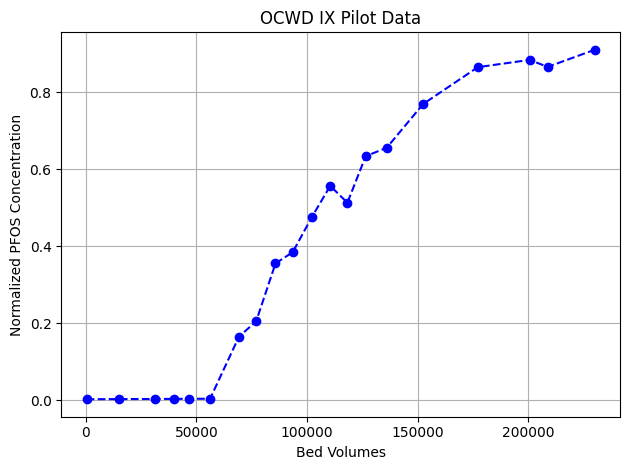

In [24]:
ix_data = pd.read_csv("ix_ocwd_data.csv")
data = ix_data[ix_data.curve_id == 1].copy()
data = data.iloc[:-1].copy()
fig, ax = plt.subplots()
ax.plot(data["bv"], data["c_norm"], marker="o", color="blue", ls="--")
ax.set_xlabel("Bed Volumes")
ax.set_ylabel("Normalized PFOS Concentration")
ax.set_title("OCWD IX Pilot Data")
ax.grid(visible=True)
fig.tight_layout()

In [ ]:

def build_ix_ocwd_pilot(
    species="PFOA", resin="calgon_calres_2301", theta_dict=dict(), **kwargs
):
    """
    Build for OCWD IX Pilot System
    """
    # PILOT SYSTEM INFO
    
    global ion_props

    bed_depth = 29 * pyunits.inch
    flow_rate = 0.2 * pyunits.gallon / pyunits.minute
    ebct = 2.07 * pyunits.minute

    pfas_data = pfas_properties[species]
    resin_data = resin_properties[resin]

    ion_props = {
        "solute_list": [species],
        "mw_data": {
            "H2O": 0.018,
            species: pfas_data.get("mw", 0.414),
        },
        "molar_volume_data": {
            ("Liq", species): pfas_data.get("molar_volume", 0.0004),
        },
        "diffus_calculation": "HaydukLaudie",
        "charge": {species: -1},
    }
    {'solute_list': ['PFOA'],
 'mw_data': {'H2O': 0.018, 'PFOA': 0.41407},
 'molar_volume_data': {('Liq', 'PFOA'): 0.000272},
 'diffus_calculation': 'HaydukLaudie',
 'charge': {'PFOA': -1}}

    m = ConcreteModel()
    m.fs = FlowsheetBlock(dynamic=False)
    m.fs.properties = MCASParameterBlock(**ion_props)
    ix_config = {
        "property_package": m.fs.properties,
        "target_ion": species,
    }
    m.fs.unit = ix = IonExchange0D(**ix_config)

#     # Set pilot feed conditions
#     pfas_mol_flow = (
#         pfas_data["c0"]
#         * pyunits.ng
#         / pyunits.L
#         / (pfas_data["mw"] * pyunits.kg / pyunits.mol)
#         * flow_rate
#     )
#     h2o_mol_flow = 55.5 * pyunits.mol / pyunits.L * flow_rate
#     ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", "H2O"].fix(h2o_mol_flow)
#     ix.process_flow.properties_in[0].flow_mol_phase_comp["Liq", species].fix(
#         pfas_mol_flow
#     )
#     ix.process_flow.properties_in[0].pressure.fix(101325)
#     ix.process_flow.properties_in[0].temperature.fix(298)

#     # Adjust bounds for pilot system
#     ix.bed_depth.setlb(0)
#     ix.bed_diameter.setlb(0)
#     ix.ebct.setlb(0)
#     ix.loading_rate.setlb(0)
#     ix.loading_rate.setub(1)
#     m.fs.unit.freundlich_n.setlb(1.05)
#     m.fs.unit.freundlich_n.setub(100)
#     m.fs.unit.bv.setlb(None)

#     ix.resin_density.fix(resin_data["density"])
#     ix.resin_diam.fix(resin_data["diameter"])
#     ix.bed_depth.fix(bed_depth)
#     ix.ebct.fix(ebct)
#     ix.number_columns.fix(1)
#     ix.c_norm.fix(0.5)

#     for theta, val in theta_dict.items():
#         ixv = m.find_component(theta)
#         ixv.fix(val)

#     m.fs.properties.set_default_scaling(
#         "flow_mol_phase_comp", 1 / value(h2o_mol_flow), index=("Liq", "H2O")
#     )
#     m.fs.properties.set_default_scaling(
#         "flow_mol_phase_comp", 1 / value(pfas_mol_flow), index=("Liq", species)
#     )

#     iscale.calculate_scaling_factors(m)

#     assert degrees_of_freedom(m) == 0
#     m.fs.unit.initialize()
#     results = solver.solve(m)
#     assert_optimal_termination(results)

#     return m

build_ix_ocwd_pilot()
ion_props

{'solute_list': ['PFOA'],
 'mw_data': {'H2O': 0.018, 'PFOA': 0.41407},
 'molar_volume_data': {('Liq', 'PFOA'): 0.000272},
 'diffus_calculation': 'HaydukLaudie',
 'charge': {'PFOA': -1}}